### Описание проекта
В датасете собраны исторические данные о заказах такси в аэропортах. Нужно спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Описание данных
Количество заказов находится в столбце '*num_orders*'.

### 1. Предобработка данных

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from ipywidgets import IntProgress, Text
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [28]:
#Загрузим данные
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [29]:
#Посмотрим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [30]:
data.index.is_monotonic

True

In [31]:
#Ресемплируем данные по сумме заказов в час
data = data.resample('1H').sum()

Данные приведены к нужным типам. Пропусков нет. Даты упорядочены. Можно переходить к анализу.

### 2. Анализ данных

Для начала построим график нашего временного ряда и добавим н него график скользящего среднего с разным значением окна (1 - среднее за час, 148 - среднее за неделю)

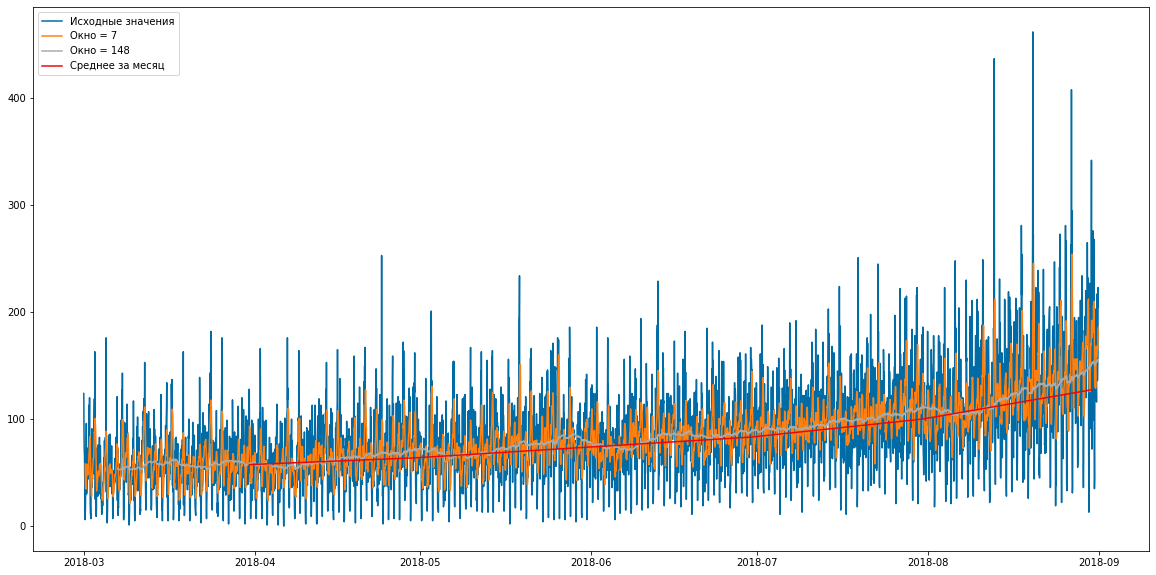

In [32]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data)
plt.plot(data.rolling(7).mean())
plt.plot(data.rolling(148).mean())
plt.plot(data.resample('1m').mean(), color='#ee0606')
plt.legend(['Исходные значения','Окно = 7', 'Окно = 148', 'Среднее за месяц'])
plt.show()

При добавлении на график значения среднего по месяцам, становится видно ярко выраженный восходящий тренд. Значит наш ряд не стационарен. С помощью метода seasonal_decompose из библиотеки statsmodels, посмотрим подробнее на тренд, сезонность и остатки.

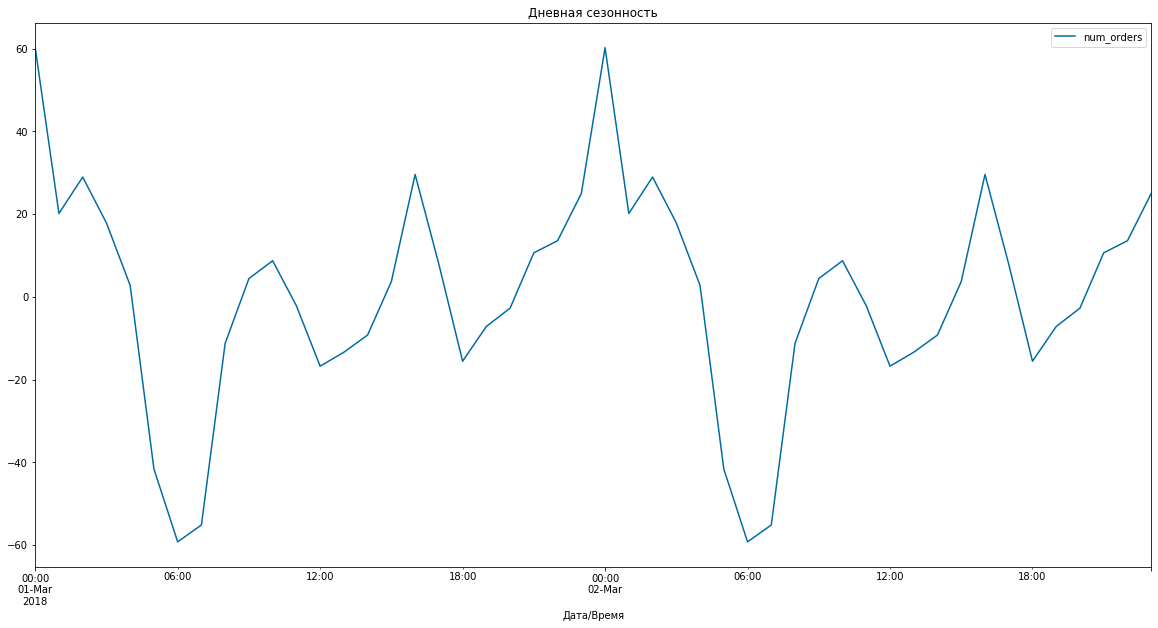

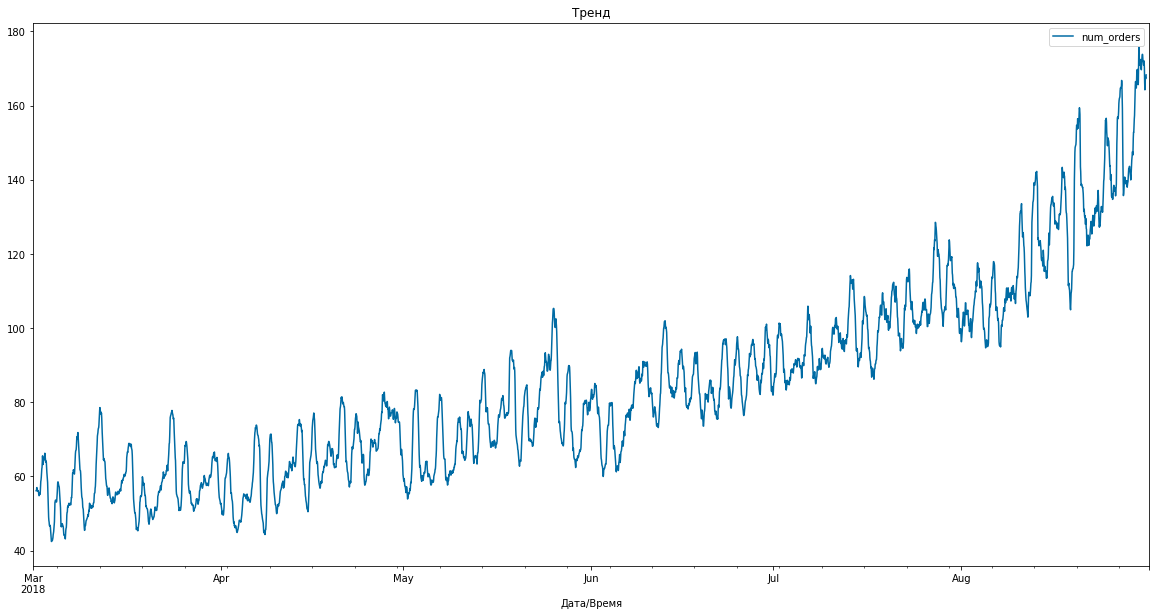

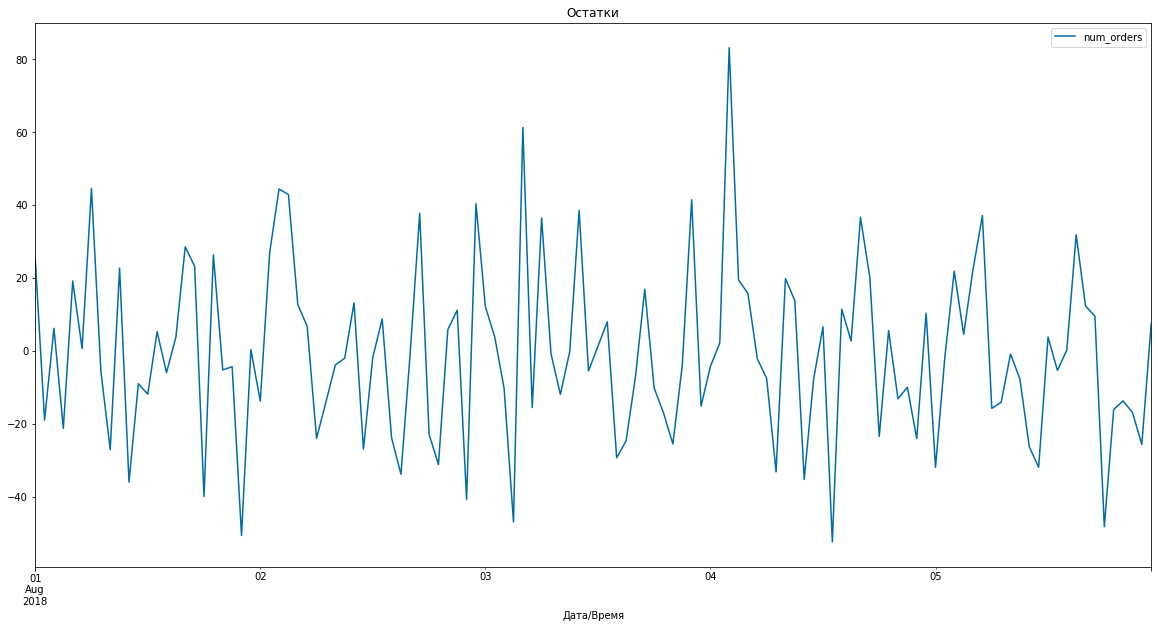

In [33]:
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()
plt.title('Дневная сезонность')
plt.xlabel('Дата/Время')
plt.show()
decomposed.trend.plot()
plt.title('Тренд')
plt.xlabel('Дата/Время')
plt.show()
decomposed.resid['2018-08-01':'2018-08-05'].plot()
plt.title('Остатки')
plt.xlabel('Дата/Время')
plt.show()

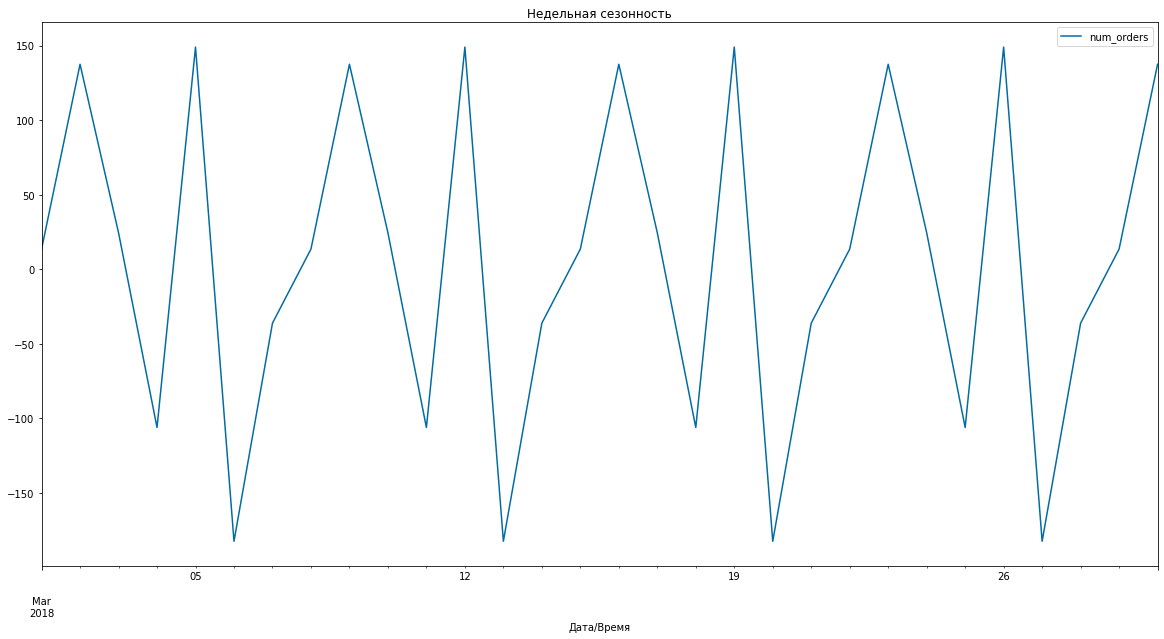

In [34]:
decomposed = seasonal_decompose(data.resample('1D').sum())
decomposed.seasonal['2018-03-01':'2018-03-30'].plot()
plt.title('Недельная сезонность')
plt.xlabel('Дата/Время')
plt.show()

В нашем временном ряду присутствуют:
- ярко выраженный восходящий тренд;
- дневная сезонность;
- недельная сезонность.

Для такого типа временного ряда подходят модели: HoltWinters (tripple exponential smoothing), линейная регрессия. Линейную регрессию обучим на обучающем наборе с добавлением новых признаков.
Обучим и протестируем модели.

### 3. Обучение моделей

In [35]:
#Выберем обучающую, валидационную и тестовую выборки
train, test_valid = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(test_valid, shuffle=False, test_size=0.5)

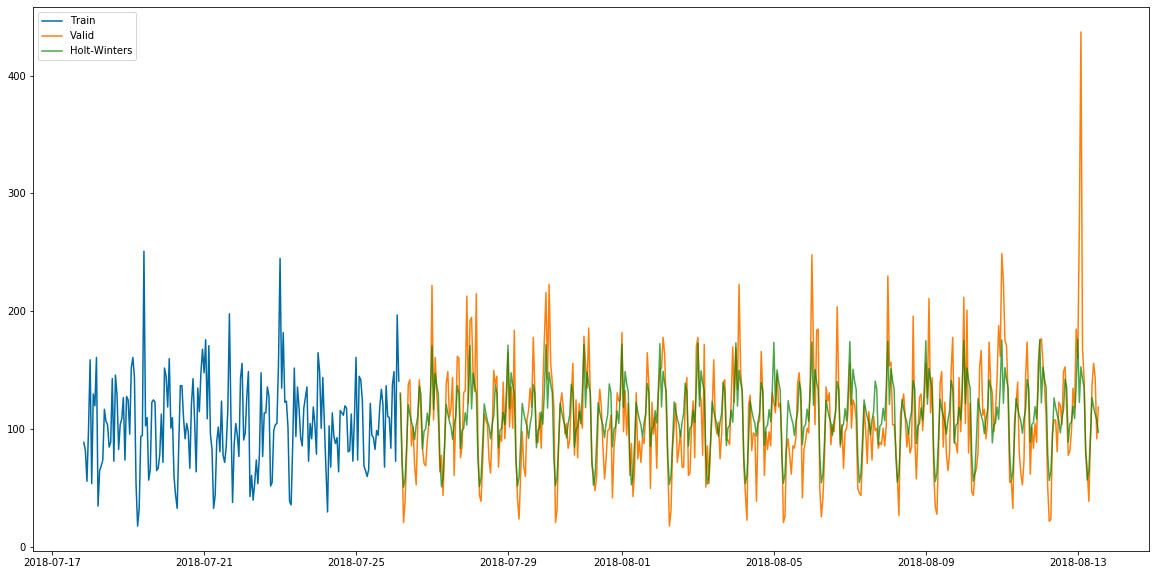

In [36]:
#Обучим модель Хольта-Винтерса, задав параметр seasonal_period = 24 (дневная сезонность)
holtwinters_model = ExponentialSmoothing(train, seasonal_periods=24, trend='add', seasonal='add').fit()
#Сделаем прогноз
predictions = holtwinters_model.predict(start=valid.index[0], end=valid.index[-1])
#Отобразим на графике обучающую и валидационную выборки и наш прогноз
plt.plot(train.tail(200), label='Train')
plt.plot(valid, label='Valid')
plt.plot(predictions, label='Holt-Winters', color='green', alpha=0.7)
plt.legend()
plt.show()

In [37]:
#Посчитаем RMSE модели
mean_squared_error(valid, predictions) ** 0.5

31.074427587270105

Мы получили неплохое приближение даже "из коробки". Но как видно на графике, наша модель не учитывает недельную сезонность. Попробуем обучить модель Хольта-Винтерса задав параметр seasonal_period = 24*7 (недельная сезонность)

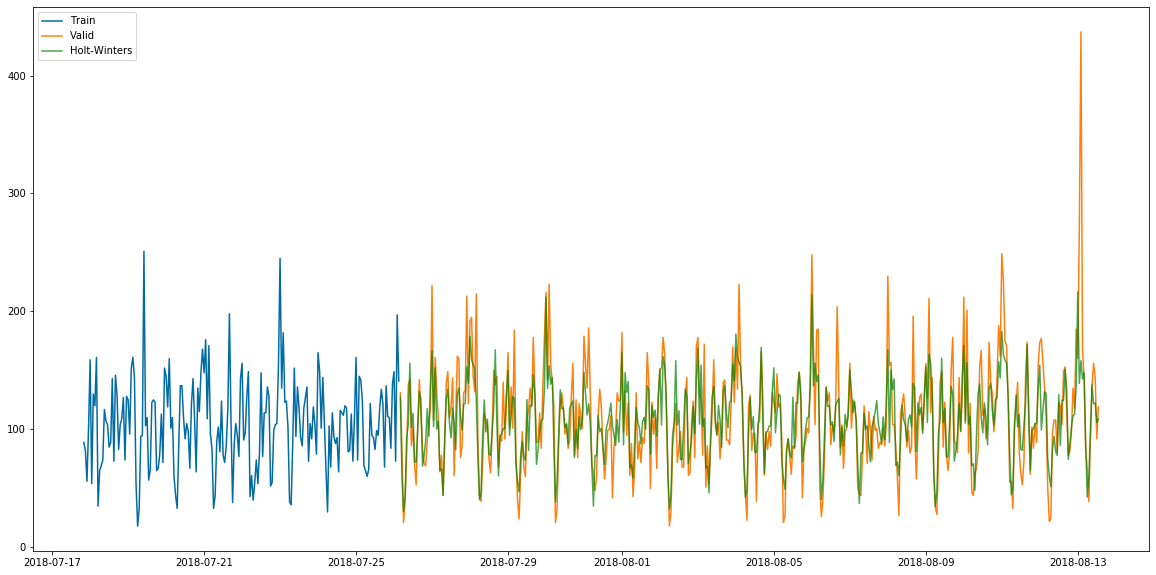

In [38]:
#Обучим модель Хольта-Винтерса, задав параметр seasonal_period = 24*7 (недельная сезонность)
holtwinters_model = ExponentialSmoothing(train, seasonal_periods=24*7, trend='add', seasonal='add').fit()
#Сделаем прогноз
predictions = holtwinters_model.predict(start=valid.index[0], end=valid.index[-1])
#Отобразим на графике обучающую и тестовую выборки и наш прогноз
plt.plot(train.tail(200), label='Train')
plt.plot(valid, label='Valid')
plt.plot(predictions, label='Holt-Winters', color='green', alpha=0.7)
plt.legend()
plt.show()

In [39]:
#Посчитаем RMSE модели
mean_squared_error(valid, predictions) ** 0.5

27.786001381145095

При обчении модели на недельной сезонности мы получили меньшую ошибку. Значит недельная сезонность более предпочтительная при обучении модели.

Обучим и протестируем модель линейной регрессии. Извлечём дополнительные признаки, для этого напишем функцию которая:
- принимает обучающий и тестовый набор данных
- объединяет оба набора для того, чтобы в тестовый добавить нужные признаки
- добавляет часовой лаг и лаги соответствующие сезонности (24 и 24*7)
- добавляет скользящее среднее по предыдущему значению с окном 7 и 7*24
- добавляет категориальные признаки: номер часа и номер дня недели
- при помощи OrdinalEncoder преобразует все категориальные пременные из строк в числа
- при помощи OneHotEncoder преобразует категориальные признаки в бинарные
- возвращает обучающий и тестовый наборы

In [40]:
def extract_features_for_regression(train, real):
    
    r_data = train.append(real)
    
    '''
    for lag in range(1, lags_count+1):
        r_data['lag_{}'.format(lag)] = r_data['num_orders'].shift(lag*24)
    '''
    r_data['lag_h'] = r_data['num_orders'].shift(1)
    r_data['lag_d'] = r_data['num_orders'].shift(24)
    r_data['lag_w'] = r_data['num_orders'].shift(24*7)
    
    r_data['rolling_mean_24'] = r_data['num_orders'].shift().rolling(24).mean()
    r_data['rolling_mean_24*7'] = r_data['num_orders'].shift().rolling(24*7).mean()
    
    r_data.dropna(inplace=True)
    
    r_data['hour'] = r_data.index.hour
    r_data['weekday'] = r_data.index.weekday
    
    ordinal_encoder = OrdinalEncoder()
    r_data[['hour', 'weekday']] = ordinal_encoder.fit_transform(r_data[['hour', 'weekday']])
    
    ohe = OneHotEncoder()
    r_data = r_data.join(pd.DataFrame(ohe.fit_transform(r_data[['hour', 'weekday']]).toarray(), index=r_data.index))
    r_data = r_data.drop(['hour', 'weekday'], axis=1)
    
    r_train, r_test = train_test_split(r_data, shuffle=False, test_size=len(real))
    
    return r_train, r_test

Обучим модель линейной регрессии с различным кол-вом лагов.

In [43]:
#Извлечём дополнительные признаки
regression_train, regression_valid = extract_features_for_regression(train, valid)

#Выделим целевой признак
regression_train_features = regression_train.drop('num_orders', axis=1)
regression_train_target = regression_train['num_orders']
regression_valid_features = regression_valid.drop('num_orders', axis=1)
regression_valid_target = regression_valid['num_orders']

#Обучим модель
regression_model = LinearRegression()
regression_model.fit(regression_train_features, regression_train_target)

#Сделаем прогноз
regression_predictions = regression_model.predict(regression_valid_features)

regression_predictions = pd.DataFrame(regression_predictions, index=regression_valid_target.index, columns=['num_orders'])

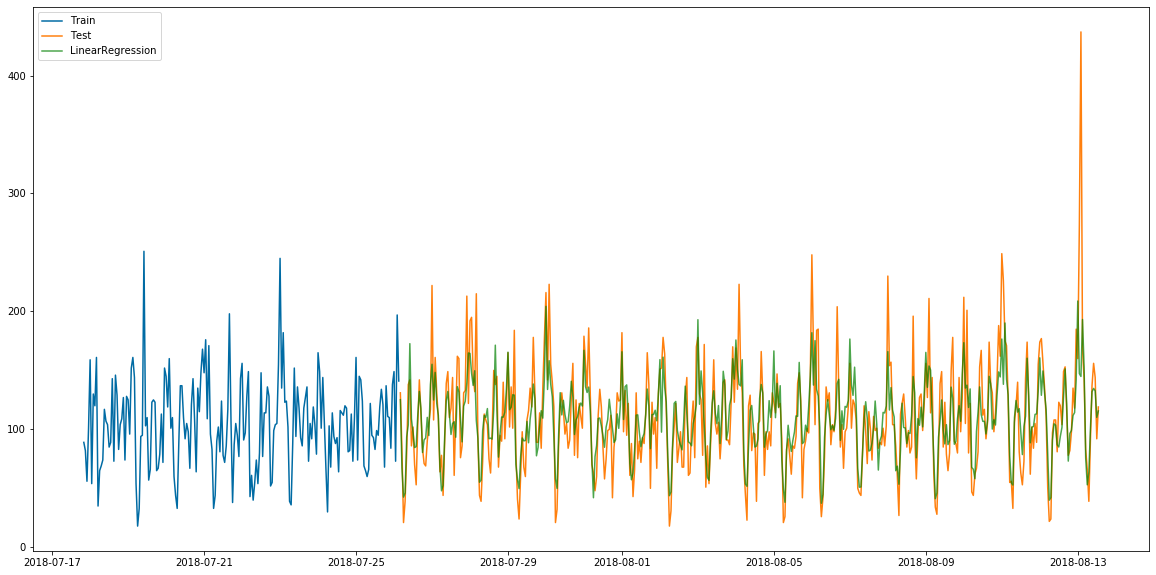

In [16]:
#Отобразим на графике обучающую и тестовую выборки и наш прогноз
plt.plot(train.tail(200), label='Train')
plt.plot(valid, label='Test')
plt.plot(regression_predictions, label='LinearRegression', color='green', alpha=0.7)
plt.legend()
plt.show()

In [17]:
#Посчитаем ошибку
mean_squared_error(regression_valid_target, regression_predictions) ** 0.5

29.29480437287174

### 3. Тестирование моделей
#### 3.1 Модель Хольта-Винтерса

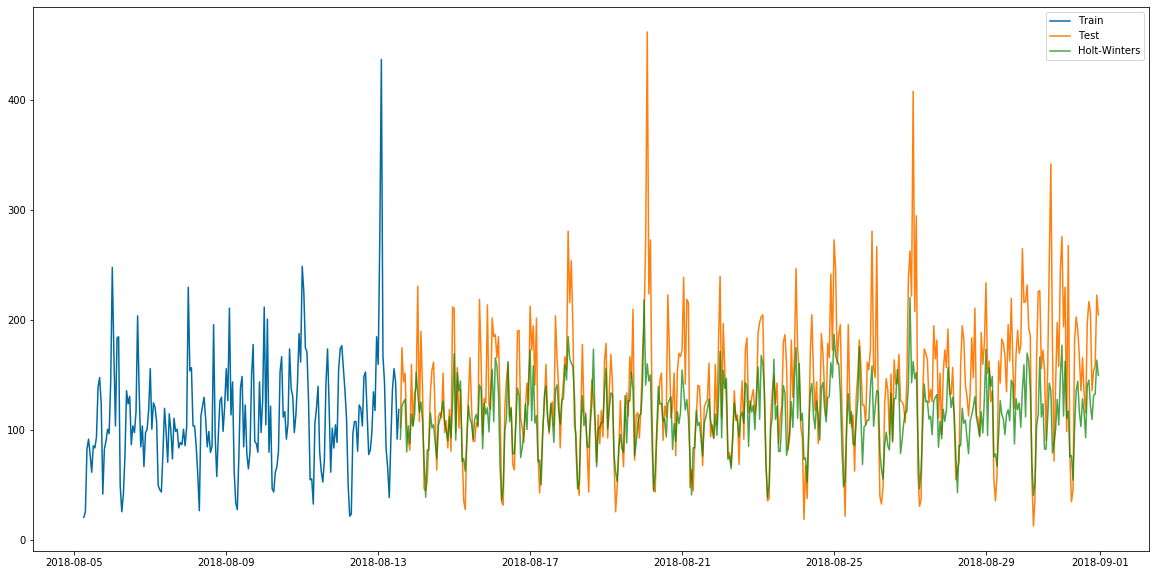

In [18]:
#Сделаем прогноз
predictions = holtwinters_model.predict(start=test.index[0], end=test.index[-1])
#Отобразим на графике обучающую и тестовую выборки и наш прогноз
plt.plot(train.append(valid).tail(200), label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Holt-Winters', color='green', alpha=0.7)
plt.legend()
plt.show()

In [19]:
#Посчитаем RMSE модели
mean_squared_error(test, predictions) ** 0.5

47.85950424832062

#### 3.2 Линейная регрессия

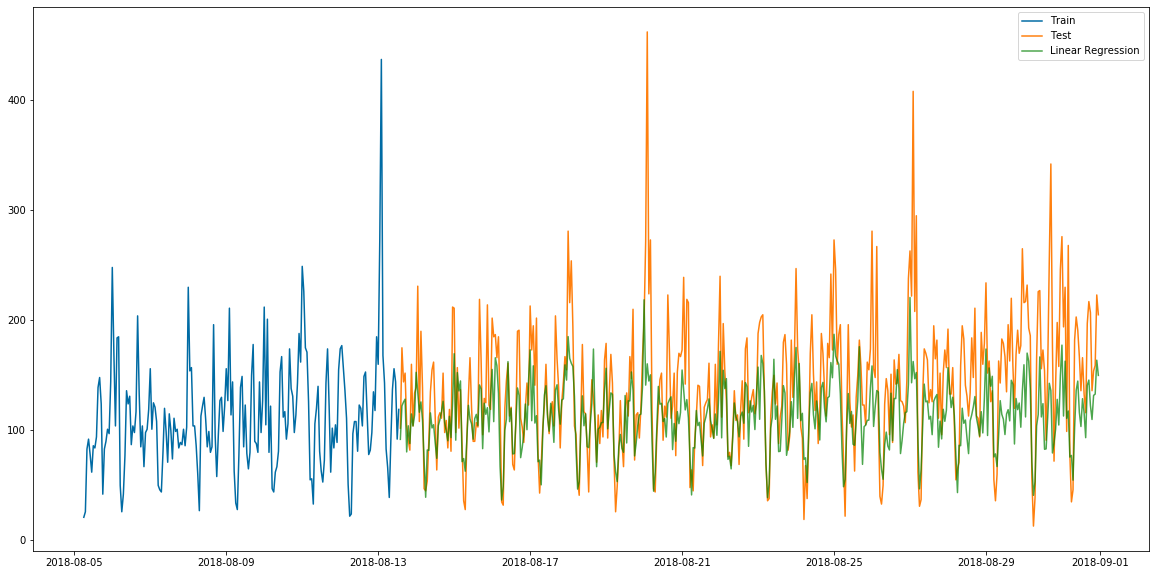

In [20]:
#Извлечём дополнительные признаки
regression_train, regression_test = extract_features_for_regression(train.append(valid), test)
#Выделим целевой признак
regression_test_features = regression_test.drop('num_orders', axis=1)
regression_test_target = regression_test['num_orders']
#Сделаем прогноз
regression_predictions = regression_model.predict(regression_test_features)
regression_predictions = pd.DataFrame(regression_predictions, index=regression_test_target.index, columns=['num_orders'])
#Отобразим на графике обучающую и тестовую выборки и наш прогноз
plt.plot(train.append(valid).tail(200), label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Linear Regression', color='green', alpha=0.7)
plt.legend()
plt.show()

In [21]:
#Посчитаем RMSE модели
mean_squared_error(test, regression_predictions) ** 0.5

35.2354845702438

 По итогу наименьшую ошибку показала модель линейной регрессии.